# Final model training

Experiment E1-15c:
- binary classification
- dataset train full 8k, val 2k
- BATCH_SIZE = 20
- IMAGE_SIZE = 384
- EPOCHS = 20
- criterion = nn.BCEWithLogitsLoss()
- optimizer = Adam
- lr=1e-5
- augmentation

model:
- self.base_model(x)
- unfreeze 4 layers
- self.globalavg(x) # (2,2)
- self.flatten(x)
- self.fc(x) # (5120,512)->Relu->Dropout(0.5)->(512,1)

In [15]:
import numpy as np
import os
import sys
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms, models
import torchvision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from PIL import Image

In [14]:
# load common py
sys.path.append('../src')
import config
import common_utils
import data_utils
import train_utils
import plot_utils


In [20]:
# override config for experiment
EXP_CODE = "E1-15c"
SAVE_FILENAME = f"stage1-{EXP_CODE}-metrics"
MODEL_SAVE_PATH = f"stage1-{EXP_CODE}-model.pth"
ONNX_SAVE_PATH = f"stage1-{EXP_CODE}-model.onnx"
ONNX_INT_SAVE_PATH = f"stage1-{EXP_CODE}-model-int8.onnx"

config.EPOCHS = 20
config.LEARNING_RATE = 1e-5
config.IMAGE_SIZE = 384

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

common_utils.set_seed(config.SEED)


In [5]:
df = pd.read_csv(config.TRAIN_CSV)

In [6]:
# split data into train, val, test 70/15/15
# for fast training, use only 3500 and 1500 samples for train and val

train_df, val_df, test_df, _, _ = data_utils.split_data(df, config.SEED)

In [7]:
print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 9097, Val size: 1950, Test size: 1950


In [8]:
# combine train and val for final training
train_val_df = pd.concat([train_df, val_df]).reset_index(drop=True)
print("Train+Val samples:", len(train_val_df))

Train+Val samples: 11047


In [9]:
train_val_df.head(5)

,ImageId,ClassId,EncodedPixels,IsDefect,DefectArea,x1,y1,x2,y2,x2-x1,y2-y1,area_frac_0,area_frac_1,area_frac_2,area_frac_3,PrimaryArea,SpanCount,IsSingleArea
0,5a4af1a28.jpg,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,False
1,589dfc4f8.jpg,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,False
2,ba3fd31de.jpg,3,7159 2 7413 6 7667 9 7921 12 8175 16 8429 19 8...,1,1661,27.0,209.0,75.0,255.0,48.0,46.0,1.0,0.0,0.000000,0.000000,0,1,True
3,d8978ca15.jpg,3,297209 2 297462 5 297715 8 297969 10 298222 13...,1,13674,1160.0,2.0,1392.0,252.0,232.0,250.0,0.0,0.0,0.172414,0.827586,3,2,True
4,6d6a1fbe1.jpg,1,174858 2 175112 6 175367 10 175622 13 175876 1...,1,1706,683.0,0.0,716.0,79.0,33.0,79.0,0.0,1.0,0.000000,0.000000,1,1,True


In [10]:
# create transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [11]:
# create datasets
train_dataset = data_utils.SteelDataset(df=train_val_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=train_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                    )
test_dataset = data_utils.SteelDataset(df=test_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=test_val_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                   )


In [12]:
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE,
                          shuffle=True,
                          num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                          )

test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE,
                         shuffle=False,
                         num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                         )


In [16]:
# create model
class SteelModel(nn.Module):
    def __init__(self):
        super(SteelModel, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1').features
        for param in self.base_model.parameters():
            param.requires_grad = False

        for p in self.base_model[-4:].parameters():
            p.requires_grad = True

        # Remove original classifier
        #self.base_model.classifier = nn.Identity()

        self.globalavg = nn.AdaptiveAvgPool2d((2, 2))

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(1280 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
        )
               

    def forward(self, x):
        x = self.base_model(x)
        #print(x.shape)
        x = self.globalavg(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return x 

In [14]:
model = SteelModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

In [15]:
%%time

arr_train_acc = []
arr_train_loss = []
arr_train_precision = []
arr_train_recall = []
arr_train_f1 = []
arr_train_rocauc = []
arr_train_conf_matrix = []


idx = 0
for epoch in range(config.EPOCHS):
    train_loss, train_all_labels, train_all_preds, train_all_probs = train_utils.train_one_epoch(model, train_loader, criterion, optimizer, device)
    #val_loss, val_all_labels, val_all_preds, val_all_probs = train_utils.validate_one_epoch(model, val_loader, criterion, device)

    # train metrics
    train_accuracy = (train_all_preds == train_all_labels).mean()
    train_precision = precision_score(train_all_labels, train_all_preds)
    train_recall = recall_score(train_all_labels, train_all_preds)
    train_f1 = f1_score(train_all_labels, train_all_preds)
    train_rocauc = roc_auc_score(train_all_labels, train_all_probs)
    train_conf_matrix = confusion_matrix(train_all_labels, train_all_preds)
    train_tn, train_fp, train_fn, train_tp = train_conf_matrix.ravel()
    
    arr_train_loss.append(train_loss)
    arr_train_acc.append(train_accuracy)
    arr_train_precision.append(train_precision)
    arr_train_recall.append(train_recall)
    arr_train_f1.append(train_f1)
    arr_train_rocauc.append(train_rocauc)
    arr_train_conf_matrix.append({'tn': train_tn, 'fp': train_fp, 'fn': train_fn, 'tp': train_tp})

    
    print(idx+1)
    print(f"Epoch {epoch+1}/{config.EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    #print(f"  Val Loss  : {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    print(f"  Train Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f} | ROC AUC: {train_rocauc:.4f}")
    print(f"  Train Confusion Matrix: TN={train_tn}, FP={train_fp}, FN={train_fn}, TP={train_tp}")
    #print(f"  Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f} | ROC AUC: {val_rocauc:.4f}")
    #print(f"  Val Confusion Matrix: TN={val_tn}, FP={val_fp}, FN={val_fn}, TP={val_tp}")

    idx += 1
    #break


1
Epoch 1/20
  Train Loss: 0.4575 | Train Acc: 0.7773
  Train Precision: 0.7676 | Recall: 0.8493 | F1: 0.8064 | ROC AUC: 0.8675
  Train Confusion Matrix: TN=3465, FP=1551, FN=909, TP=5122
2
Epoch 2/20
  Train Loss: 0.3018 | Train Acc: 0.8667
  Train Precision: 0.8730 | Recall: 0.8844 | F1: 0.8787 | ROC AUC: 0.9442
  Train Confusion Matrix: TN=4240, FP=776, FN=697, TP=5334
3
Epoch 3/20
  Train Loss: 0.2642 | Train Acc: 0.8887
  Train Precision: 0.8953 | Recall: 0.9015 | F1: 0.8984 | ROC AUC: 0.9570
  Train Confusion Matrix: TN=4380, FP=636, FN=594, TP=5437
4
Epoch 4/20
  Train Loss: 0.2343 | Train Acc: 0.9019
  Train Precision: 0.9069 | Recall: 0.9141 | F1: 0.9105 | ROC AUC: 0.9663
  Train Confusion Matrix: TN=4450, FP=566, FN=518, TP=5513
5
Epoch 5/20
  Train Loss: 0.2198 | Train Acc: 0.9071
  Train Precision: 0.9118 | Recall: 0.9188 | F1: 0.9153 | ROC AUC: 0.9703
  Train Confusion Matrix: TN=4480, FP=536, FN=490, TP=5541
6
Epoch 6/20
  Train Loss: 0.2130 | Train Acc: 0.9133
  Train Pr

In [ ]:
df_metrics = config.build_metric_df_train_only(
    arr_train_loss, arr_train_acc, arr_train_precision, arr_train_recall, 
    arr_train_f1, arr_train_rocauc, arr_train_conf_matrix,
)


In [19]:
df_metrics

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,train_conf_matrix,train_tn,train_fp,train_fn,train_tp
0,0.457541,0.777315,0.767571,0.849279,0.806360,0.867459,"{'tn': 3465, 'fp': 1551, 'fn': 909, 'tp': 5122}",3465,1551,909,5122
1,0.301755,0.866661,0.872995,0.884430,0.878676,0.944246,"{'tn': 4240, 'fp': 776, 'fn': 697, 'tp': 5334}",4240,776,697,5334
2,0.264180,0.888658,0.895274,0.901509,0.898381,0.957020,"{'tn': 4380, 'fp': 636, 'fn': 594, 'tp': 5437}",4380,636,594,5437
3,0.234345,0.901874,0.906893,0.914110,0.910487,0.966265,"{'tn': 4450, 'fp': 566, 'fn': 518, 'tp': 5513}",4450,566,518,5513
4,0.219783,0.907124,0.911799,0.918753,0.915263,0.970255,"{'tn': 4480, 'fp': 536, 'fn': 490, 'tp': 5541}",4480,536,490,5541
5,0.213034,0.913280,0.917256,0.924556,0.920892,0.971949,"{'tn': 4513, 'fp': 503, 'fn': 455, 'tp': 5576}",4513,503,455,5576
6,0.196585,0.921336,0.926189,0.930028,0.928105,0.976145,"{'tn': 4569, 'fp': 447, 'fn': 422, 'tp': 5609}",4569,447,422,5609
7,0.194698,0.922966,0.928524,0.930526,0.929524,0.976517,"{'tn': 4584, 'fp': 432, 'fn': 419, 'tp': 5612}",4584,432,419,5612
8,0.180530,0.925410,0.930117,0.933510,0.931811,0.979855,"{'tn': 4593, 'fp': 423, 'fn': 401, 'tp': 5630}",4593,423,401,5630
9,0.175104,0.930479,0.933454,0.939645,0.936539,0.980882,"{'tn': 4612, 'fp': 404, 'fn': 364, 'tp': 5667}",4612,404,364,5667


In [20]:
df_metrics.describe()

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,train_tn,train_fp,train_fn,train_tp
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.194689,0.918860,0.922005,0.931015,0.926398,0.972856,4535.700000,480.300000,416.050000,5614.950000
std,0.077647,0.039832,0.041748,0.027190,0.034531,0.027467,281.616593,281.616593,163.985068,163.985068
min,0.122989,0.777315,0.767571,0.849279,0.806360,0.867459,3465.000000,294.000000,248.000000,5122.000000
25%,0.144103,0.911741,0.915892,0.923106,0.919485,0.971525,4504.750000,324.750000,302.000000,5567.250000
50%,0.172397,0.930615,0.934618,0.938567,0.936587,0.981521,4620.000000,396.000000,370.500000,5660.500000
75%,0.214722,0.943446,0.946373,0.949925,0.948311,0.986941,4691.250000,511.250000,463.750000,5729.000000
max,0.457541,0.950937,0.951621,0.958879,0.955236,0.990572,4722.000000,1551.000000,909.000000,5783.000000


In [21]:
print(df_metrics.describe())

       train_loss  train_acc  train_precision  train_recall   train_f1  \
count   20.000000  20.000000        20.000000     20.000000  20.000000   
mean     0.194689   0.918860         0.922005      0.931015   0.926398   
std      0.077647   0.039832         0.041748      0.027190   0.034531   
min      0.122989   0.777315         0.767571      0.849279   0.806360   
25%      0.144103   0.911741         0.915892      0.923106   0.919485   
50%      0.172397   0.930615         0.934618      0.938567   0.936587   
75%      0.214722   0.943446         0.946373      0.949925   0.948311   
max      0.457541   0.950937         0.951621      0.958879   0.955236   

       train_rocauc     train_tn     train_fp    train_fn     train_tp  
count     20.000000    20.000000    20.000000   20.000000    20.000000  
mean       0.972856  4535.700000   480.300000  416.050000  5614.950000  
std        0.027467   281.616593   281.616593  163.985068   163.985068  
min        0.867459  3465.000000   294.00

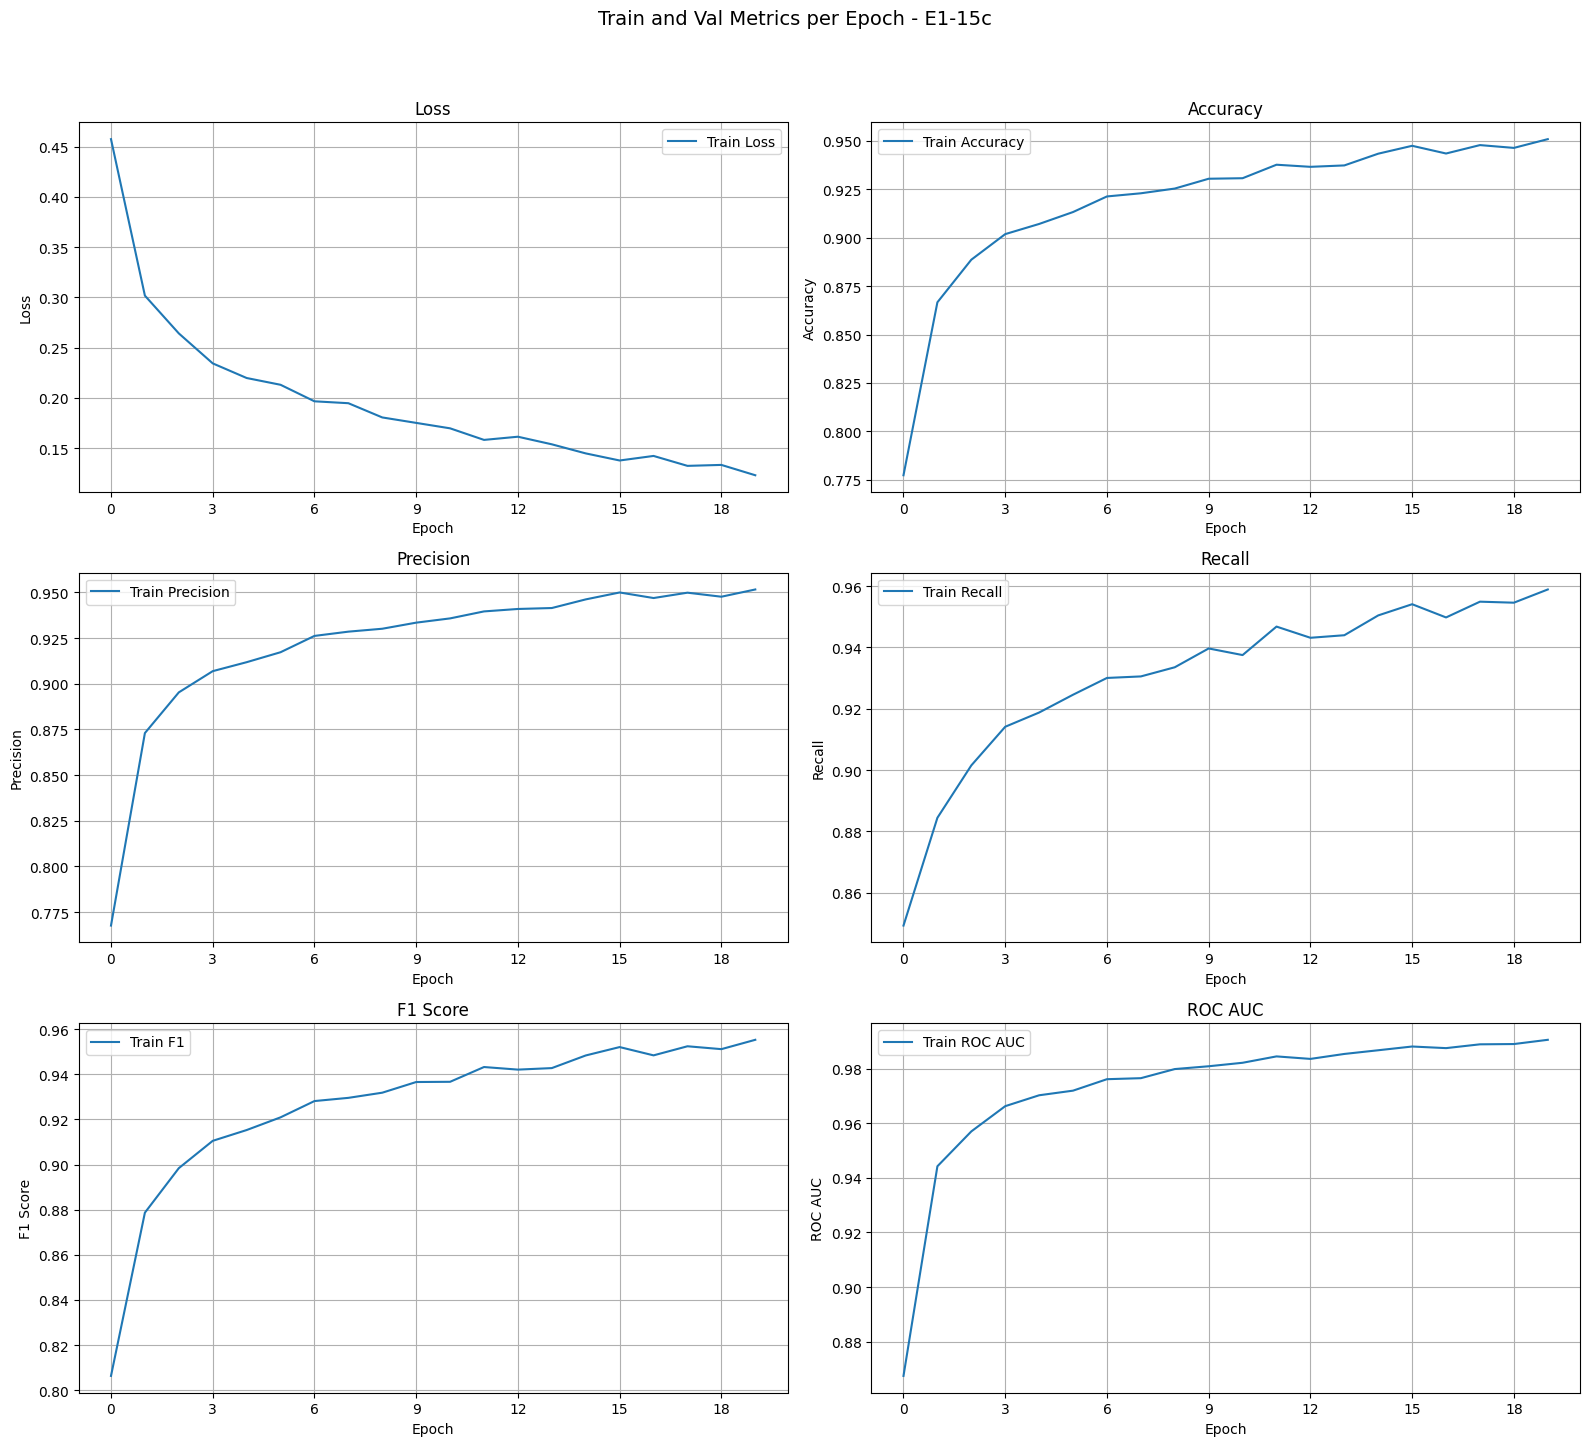

In [ ]:
plot_utils.plot_train_metrics(df_metrics, exp_code=EXP_CODE, save_path=SAVE_FILENAME+".png")

In [27]:
df_train_conf_matrix = df_metrics['train_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
#df_val_conf_matrix = df_metrics['val_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
#df_metrics[['val_tn', 'val_fp', 'val_fn', 'val_tp']]
df_train_conf_matrix.columns = ['train_tn', 'train_fp', 'train_fn', 'train_tp']
#df_val_conf_matrix.columns = ['val_tn', 'val_fp', 'val_fn', 'val_tp']



In [28]:
df_train_conf_matrix.describe()

,train_tn,train_fp,train_fn,train_tp
count,20.000000,20.000000,20.000000,20.000000
mean,4535.700000,480.300000,416.050000,5614.950000
std,281.616593,281.616593,163.985068,163.985068
min,3465.000000,294.000000,248.000000,5122.000000
25%,4504.750000,324.750000,302.000000,5567.250000
50%,4620.000000,396.000000,370.500000,5660.500000
75%,4691.250000,511.250000,463.750000,5729.000000
max,4722.000000,1551.000000,909.000000,5783.000000


In [29]:
df_metrics.to_csv(SAVE_FILENAME+".csv", index=False)

In [30]:
# save model weights

torch.save(model.state_dict(), MODEL_SAVE_PATH)


# Using test dataset

In [17]:
# load model weights
model_loaded = SteelModel()
model_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))
model_loaded = model_loaded.to(device)

In [50]:
%%time

threshold = 0.51
criterion = nn.BCEWithLogitsLoss()

arr_thresholds = []

th_test_loss, th_test_all_labels, th_test_all_preds, th_test_all_probs = train_utils.validate_one_epoch(
    model_loaded, test_loader, criterion, device, threshold
)
th_test_pred_labels = (th_test_all_probs >= threshold).astype(int)
th_test_accuracy = accuracy_score(th_test_all_labels, th_test_pred_labels)
th_test_precision = precision_score(th_test_all_labels, th_test_pred_labels)
th_test_recall = recall_score(th_test_all_labels, th_test_pred_labels)
th_test_f1 = f1_score(th_test_all_labels, th_test_pred_labels)
th_test_rocauc = roc_auc_score(th_test_all_labels, th_test_all_probs)
th_test_conf_matrix = confusion_matrix(th_test_all_labels, th_test_pred_labels)
th_test_tn, th_test_fp, th_test_fn, th_test_tp = th_test_conf_matrix.ravel()

arr_thresholds.append({
    'threshold': threshold,
    'accuracy': th_test_accuracy,
    'precision': th_test_precision,
    'recall': th_test_recall,
    'f1': th_test_f1,
    'rocauc': th_test_rocauc,
    'tn': th_test_tn,
    'fp': th_test_fp,
    'fn': th_test_fn,
    'tp': th_test_tp,
})

print(f"Test Loss: {th_test_loss:.4f} | Test Acc: {th_test_accuracy:.4f}")
print(f"Test Precision: {th_test_precision:.4f}")
print(f"Test Recall: {th_test_recall:.4f}")
print(f"Test F1: {th_test_f1:.4f}")
print(f"Test ROC AUC: {th_test_rocauc:.4f}")
print(f"Test Confusion Matrix: TN={th_test_tn}, FP={th_test_fp}, FN={th_test_fn}, TP={th_test_tp}")


Test Loss: 0.1308 | Test Acc: 0.9508
Test Precision: 0.9690
Test Recall: 0.9398
Test F1: 0.9542
Test ROC AUC: 0.9900
Test Confusion Matrix: TN=854, FP=32, FN=64, TP=1000
CPU times: user 4.42 s, sys: 1.5 s, total: 5.92 s
Wall time: 5.11 s


In [51]:
%%time

threshold = 0.4
criterion = nn.BCEWithLogitsLoss()

arr_thresholds = []

th_test_loss, th_test_all_labels, th_test_all_preds, th_test_all_probs = train_utils.validate_one_epoch(
    model_loaded, test_loader, criterion, device, threshold
)
th_test_pred_labels = (th_test_all_probs >= threshold).astype(int)
th_test_accuracy = accuracy_score(th_test_all_labels, th_test_pred_labels)
th_test_precision = precision_score(th_test_all_labels, th_test_pred_labels)
th_test_recall = recall_score(th_test_all_labels, th_test_pred_labels)
th_test_f1 = f1_score(th_test_all_labels, th_test_pred_labels)
th_test_rocauc = roc_auc_score(th_test_all_labels, th_test_all_probs)
th_test_conf_matrix = confusion_matrix(th_test_all_labels, th_test_pred_labels)
th_test_tn, th_test_fp, th_test_fn, th_test_tp = th_test_conf_matrix.ravel()

arr_thresholds.append({
    'threshold': threshold,
    'accuracy': th_test_accuracy,
    'precision': th_test_precision,
    'recall': th_test_recall,
    'f1': th_test_f1,
    'rocauc': th_test_rocauc,
    'tn': th_test_tn,
    'fp': th_test_fp,
    'fn': th_test_fn,
    'tp': th_test_tp,
})

print(f"Test Loss: {th_test_loss:.4f} | Test Acc: {th_test_accuracy:.4f}")
print(f"Test Precision: {th_test_precision:.4f}")
print(f"Test Recall: {th_test_recall:.4f}")
print(f"Test F1: {th_test_f1:.4f}")
print(f"Test ROC AUC: {th_test_rocauc:.4f}")
print(f"Test Confusion Matrix: TN={th_test_tn}, FP={th_test_fp}, FN={th_test_fn}, TP={th_test_tp}")


Test Loss: 0.1308 | Test Acc: 0.9533
Test Precision: 0.9638
Test Recall: 0.9502
Test F1: 0.9569
Test ROC AUC: 0.9900
Test Confusion Matrix: TN=848, FP=38, FN=53, TP=1011
CPU times: user 4.6 s, sys: 1.46 s, total: 6.05 s
Wall time: 4.87 s


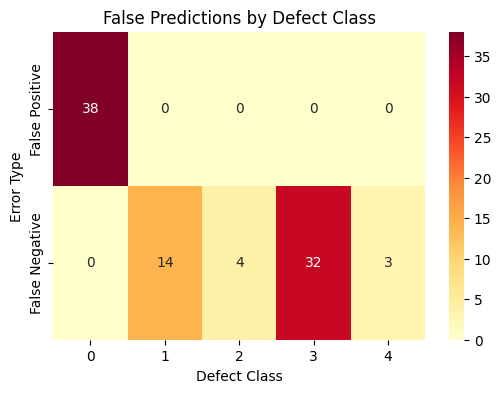

In [52]:

# Get indices of false positives and false negatives
fp_indices = np.where((th_test_all_labels == 0) & (th_test_pred_labels == 1))[0]
fn_indices = np.where((th_test_all_labels == 1) & (th_test_pred_labels == 0))[0]

# Get the corresponding rows in test_df for FP and FN
fp_classes = test_df.iloc[fp_indices]['ClassId']
fn_classes = test_df.iloc[fn_indices]['ClassId']

# Count occurrences for each class
fp_counts = fp_classes.value_counts().sort_index()
fn_counts = fn_classes.value_counts().sort_index()

# Combine into a DataFrame for heatmap
heatmap_data = pd.DataFrame({'False Positive': fp_counts, 'False Negative': fn_counts}).fillna(0).astype(int)

plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data.T, annot=True, fmt="d", cmap="YlOrRd")
plt.title("False Predictions by Defect Class")
plt.xlabel("Defect Class")
plt.ylabel("Error Type")
plt.show()

In [53]:
heatmap_data

,False Positive,False Negative
ClassId,,
0,38,0
1,0,14
2,0,4
3,0,32
4,0,3


# Convert to onnx

In [19]:
dummy_input = torch.randn(1, 3, config.IMAGE_SIZE, config.IMAGE_SIZE, device=device)
torch.onnx.export(
    model_loaded,              # torch model in eval mode
    dummy_input,               # sample input tensor
    ONNX_SAVE_PATH,              # onnx output filename
    input_names=["input"],     # name of onnx graph input
    output_names=["output"],   # name of onnx graph output
    opset_version=18,          # onnx operator standard version, current latest value is 18
    do_constant_folding=True,  # precomputes constant operations to reduce size & improve speed
    dynamo=False,               # Use new exporter, need onnxscript (pip install onnxscript)
)

/tmp/ipykernel_81122/2999447935.py:2: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


# Convert onnx to int quantization

In [25]:
import onnxruntime as ort
ort.__version__

'1.23.2'

In [29]:
from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantType, QuantFormat

# Simple data reader for calibration (replace with your own)
#class DummyDataReader(CalibrationDataReader):
#    def get_next(self):
#        # Provide representative input data as a dictionary
#        return {"input": np.random.randn(1, 3, config.IMAGE_SIZE, config.IMAGE_SIZE).astype(np.float32)}
class DummyDataReader(CalibrationDataReader):
    def __init__(self, num_samples=10):
        self.num_samples = num_samples
        self.count = 0
    def get_next(self):
        if self.count < self.num_samples:
            self.count += 1
            return {"input": np.random.randn(1, 3, config.IMAGE_SIZE, config.IMAGE_SIZE).astype(np.float32)}
        else:
            return None
        
quantize_static(
    model_input=ONNX_SAVE_PATH,
    model_output=ONNX_INT_SAVE_PATH,
    calibration_data_reader=DummyDataReader(),
    quant_format=QuantFormat.QOperator,   # default, optional
    weight_type=QuantType.QInt8,
    activation_type=QuantType.QUInt8,
)